In [47]:
#-*- encoding: utf8 -*-
import os
import heartpy as hp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv
import math

In [34]:
# 피험자를 선택하여 데이터 불러오는 함수
def select_subject(_subject):
    path = 'C:\\Users\\user\\Downloads\\iDAQ-400\\Software\\iDAQ400\\Data\\ASCII_data\\' + _subject
#     print path
    _listOfData= [path+'\\' +_subject + '_ref.txt',
                  path+'\\' +_subject + '_calm.txt',
                  path+'\\' +_subject + '_horror.txt',
                  path+'\\' +_subject + '_happy.txt',
                  path+'\\' +_subject + '_sad.txt']
#     print _listOfData
    
    return _listOfData

In [37]:
# 전처리 함수(lowpass&highpass filter)
def preprocessing(hrdata):
    filtered = hp.filter_signal(hrdata, cutoff = 0.70, sample_rate = 500.0, order = 3, filtertype='lowpass')
    filtered = hp.filter_signal(hrdata, cutoff = 3.0, sample_rate = 500.0, order = 3, filtertype='highpass')
    return filtered
# filt = preprocessing(hrList[0])
# print(filt)

In [6]:
# peak 찾는 함수(amplitude)
def detect_peak(hrdata):
    point=scipy.signal.find_peaks(hrdata,distance=200)
#     print(point[0])
    plt.scatter(point[0],hrdata[point[0]])
    plt.plot(hrdata)
    peak=np.zeros(len(point[0]))
    for i in range(len(point[0])):
        peak[i]=(hrdata[point[0][i]])
#     print(peak)
    return(peak,point[0])
# detect_peak(hrdata)

In [7]:
#주기찾는 함수 
def find_period(points, samplingrate):
    # index -> time
    for i in range(len(points)):
        points[i]=float(points[i])/samplingrate
    period=[]
    for i in range(len(points)-1):
        period.append(points[i+1]-points[i])
#     print('period:',period)
    return(period)
# period=find_period(peak)

In [8]:
# 평균 ppi 구하는 함수
def calculate_PPI(periods):
    PPI=0.0;
    for i in range(len(periods)):
        PPI +=periods[i]
    PPI /= len(periods)
    return PPI

In [9]:
# 평균 amplitude 구하는 함수
def calculate_Amplitude(hrpeaks):
    amplitude=0.0;
    for i in range(len(hrpeaks)):
        amplitude +=hrpeaks[i]
    amplitude /= len(hrpeaks)
    return amplitude

In [10]:
# 레퍼런스 대비 변화율 계산하는 함수
def calculate_ChangeRate(ref,x):
    changeRate = (x-ref)/ref
    return changeRate

In [35]:
# 변화율 csv로 출력하는 함수
# output.csv에 변화율 이어쓰기
def write_csv(_subject, list_amp,list_ppi):
    f = open('C:\\Users\\user\\Downloads\\iDAQ-400\\Software\\iDAQ400\\Data\\analysis\\ppg_output.csv', 'a')
    wr = csv.writer(f)
    for i in range(len(list_amp)):
        wr.writerow([_subject + " " + str(i+1), str(list_amp[i]), str(list_ppi[i])])
    f.close()

In [42]:
# 피험자별 영상별 ppi,amplitude 구하여 csv에 출력하는 함수
def analyze_dataset(_subject, _samplingrate):
    # 데이터 불러오기
    # subject에 분석할 피험자 이름 설정하기!
    subject=_subject
    samplingRate = _samplingrate # 500hz
    listOfData = select_subject(subject)

    hrList=[0 for i in range(5)]  # ppg raw data
    filtered_hrList=[[None] for row in range(5)]
    hrpeaks=[[None] for row in range(5)]  # peak amplitudes
    hrpoints=[[None] for row in range(5)]  # peak index
    hrperiods=[[None] for row in range(5)]  # PPIs
    amplitudes=[0 for i in range(5)]  # 영상별 평균 amp리스트
    PPIs=[0 for i in range(5)]  # 영상별 평균 ppi리스트
    changeRates_amp=[0 for i in range(4)]  # 영상별 amp변화율
    changeRates_ppi=[0 for i in range(4)]  # 영상별 ppi변화율

    # 레퍼런스 및 영상별 평균 amplitude, ppi 계산
    # 0=ref, 1=평온, 2=공포, 3=기쁨, 4=슬픔
    for i in range(5):
        hrList[i] = hp.get_data(listOfData[i])
        filtered_hrList[i] = preprocessing(hrList[i])  # low&highpass
        hrpeaks[i],hrpoints[i] = detect_peak(filtered_hrList[i])
        hrperiods[i]=find_period(hrpoints[i],samplingRate)
        amplitudes[i]=calculate_Amplitude(hrpeaks[i])
        PPIs[i]=calculate_PPI(hrperiods[i])

    # 영상별 레퍼런스 대비 변화율 계산
    for i in range(5):
        # ref
        if i==0:
            ref_amplitude = amplitudes[i]
            ref_PPI = PPIs[i]
        else:
            changeRates_amp[i-1]=calculate_ChangeRate(ref_amplitude, amplitudes[i])
            changeRates_ppi[i-1]=calculate_ChangeRate(ref_PPI, PPIs[i])

    # 변화율 출력
    for i in range(len(changeRates_amp)):
        print('[' + str(i) + '번째]\n' )
        print("amplitude: "+ str(changeRates_amp[i]) + '\n')
        print("ppi : "+ str(changeRates_ppi[i]) + '\n')

    # 변화율 csv 출력
    write_csv(subject,changeRates_amp,changeRates_ppi)

In [52]:
# 두 점 사이의 거리를 구하여 감성을 선택
def select_emotion(_amp, _ppi):
    emotionList=['calm', 'scary', 'happy', 'sad']
    # 가상의 감성별 amp, ppi 지표값 리스트(지표값 구했으면 여기 리스트값 바꾸기!)
    # 0=평온, 1=공포, 2=기쁨, 3=슬픔
    normList_amp=[-0.7823643050928237484, -0.08288524590163936,
                   -0.18949358241199646, -0.6393663714179988]
    normList_ppi=[-0.1186371274057131, -0.6393663714179988,
                  -0.6804606633045137, -0.08288524590163936]
    distances=[0 for i in range(4)]
    # 거리 구하기
    for i in range(len(distances)):
        distances[i]=math.sqrt(pow(_amp - normList_amp[i],2) + 
                              pow(_ppi - normList_ppi[i],2))
    # 최소 거리의 지표의 감성 채택
    min_distance=100
    for i in range(len(distances)):
        if(distances[i]<min_distance):
            min_distance = distances[i]
            min_index = i
    
    return emotionList[min_index]

In [59]:
# 감성 분석 함수
def analyze_emotion(_user,_samplingrate):
    listOfData = select_subject(_user)
    changeRates_amp=[0 for i in range(4)]  # 영상별 amp변화율
    changeRates_ppi=[0 for i in range(4)]  # 영상별 ppi변화율
    # 레퍼런스 및 영상별 평균 amplitude, ppi 계산
    # 0=ref, 1=평온, 2=공포, 3=기쁨, 4=슬픔
    for i in range(len(listOfData)):
        hrList[i] = hp.get_data(listOfData[i])
        filtered_hrList[i] = preprocessing(hrList[i])  # low&highpass
        hrpeaks[i],hrpoints[i] = detect_peak(filtered_hrList[i])
        hrperiods[i]=find_period(hrpoints[i],_samplingrate)
        amplitudes[i]=calculate_Amplitude(hrpeaks[i])
        PPIs[i]=calculate_PPI(hrperiods[i])
        
        # 영상별 레퍼런스 대비 변화율 계산
    for i in range(5):
        # ref
        if i==0:
            ref_amplitude = amplitudes[i]
            ref_PPI = PPIs[i]
        else:
            changeRates_amp[i-1]=calculate_ChangeRate(ref_amplitude, amplitudes[i])
            changeRates_ppi[i-1]=calculate_ChangeRate(ref_PPI, PPIs[i])
        
        
#     # 변화율 출력
#     for i in range(len(changeRates_amp)):
#         print('[' + str(i) + '번째]\n' )
#         print("amplitude: "+ str(changeRates_amp[i]) + '\n')
#         print("ppi : "+ str(changeRates_ppi[i]) + '\n')
        
    # 각 영상에 대한 감성 선택
    selected_emotions=[0 for i in range(4)]
    # 영상별 감성 측정 (지표와의 거리가 척도)
    for i in range(len(changeRates_amp)):
        selected_emotions[i]=select_emotion(changeRates_amp[i],changeRates_ppi[i])
        
    # 각 영상을 보고 느낀 감성 출력
    for i in range(len(selected_emotions)):
        print str(i)+"번째 영상을 보고 느낀 감성 :" + selected_emotions[i]

C:\Users\user\Downloads\iDAQ-400\Software\iDAQ400\Data\ASCII_data\knh
[0번째]

amplitude: -0.7823643050464422

ppi : -0.18949358241199646

[1번째]

amplitude: -0.5417597282988641

ppi : -0.1186371274057131

[2번째]

amplitude: -0.6804606633045137

ppi : -0.08288524590163936

[3번째]

amplitude: -0.6393663714179988

ppi : -0.08903817834410412



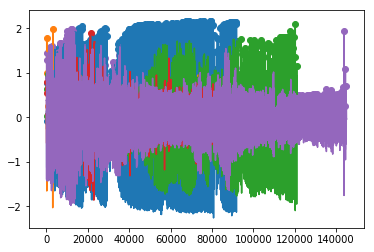

In [43]:
# 피험자별 실험 데이터 분석
subject='knh'  # 피험자 아이디
sampingRate = 500   # 500hz
analyze_dataset(subject,sampingRate)

C:\Users\user\Downloads\iDAQ-400\Software\iDAQ400\Data\ASCII_data\knh
0번째 영상을 보고 느낀 감성 :calm
1번째 영상을 보고 느낀 감성 :sad
2번째 영상을 보고 느낀 감성 :sad
3번째 영상을 보고 느낀 감성 :sad


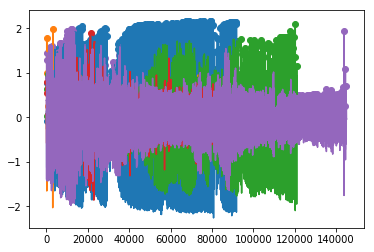

In [60]:
# 사용자 감성 분석
user='knh'  # 피험자 아이디
sampingRate = 500   # 500hz
analyze_emotion(user,samplingRate)